<h4>Download all the Dependencies required for code

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium #  map rendering library


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         673 KB

The following NEW packages will be INSTALLED:

    altair:  4.0.1-py_0 conda-forge
    branca:  0.4.0-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


bran

<h4> Define important functions

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   # CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    CLIENT_ID = '4VYXRODETYKWPUA125OB2ZFWISFJHCLNJCTMQNDDOR5X1N4T' 
    CLIENT_SECRET = 'C5EWYRVS535GWV55HYY333GEATUQ5YNWZY4SJOIC5E15QQNL' 
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    #CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    CLIENT_ID = '4VYXRODETYKWPUA125OB2ZFWISFJHCLNJCTMQNDDOR5X1N4T' 
    CLIENT_SECRET = 'C5EWYRVS535GWV55HYY333GEATUQ5YNWZY4SJOIC5E15QQNL' 
    VERSION = '20180604'
    #LIMIT = 30
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:

new_york_data.shape

(306, 4)

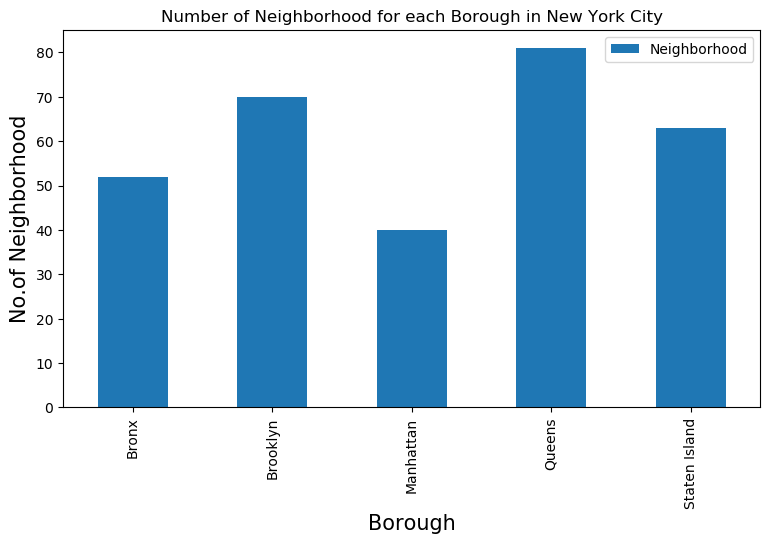

In [9]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h4> List of Indian resturants for each Neighborhood

In [10]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

KeyError: 'groups'

In [11]:

indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [12]:
indian_rest_ny.shape

(39, 4)

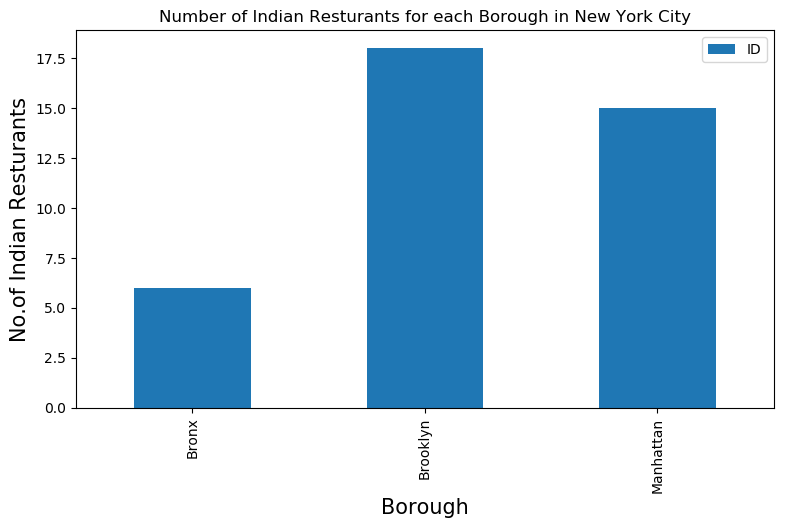

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

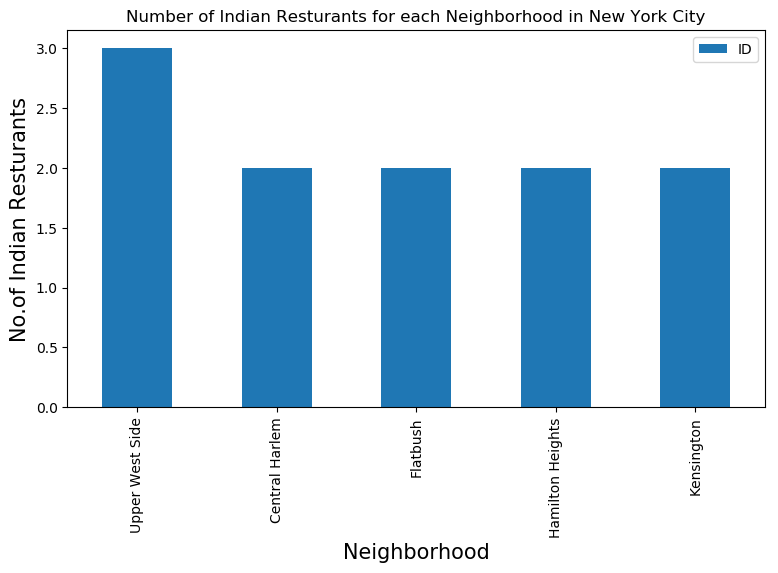

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Upper West Side']

,Borough,Neighborhood,ID,Name
34,Manhattan,Upper West Side,591890f43abcaf1ddca66e85,Ashoka
35,Manhattan,Upper West Side,42489a80f964a5208b201fe3,Swagat
36,Manhattan,Upper West Side,4b0dec08f964a520ae5223e3,Alachi Masala


Thus Upper West Side in Manhattan has highest number of restaurants i.e 3

In [16]:
# get the ranking of each resturant for further analysis.
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.0    10
( 1 / 39 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 39 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 39 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 39 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 39 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 39 ) processed
                         ID       Name  Likes  Rating  T

In [17]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [18]:

indian_rest_stats_ny.shape

(39, 7)

In [19]:
indian_rest_ny.shape

(39, 4)

In [20]:
# save data to csv
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [21]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
Borough         39 non-null object
Neighborhood    39 non-null object
ID              39 non-null object
Name            39 non-null object
Likes           39 non-null object
Rating          39 non-null float64
Tips            39 non-null object
dtypes: float64(1), object(6)
memory usage: 2.2+ KB


In [22]:
# Need certain Preprocessing to make data look alike
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [23]:

indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
Borough         39 non-null object
Neighborhood    39 non-null object
ID              39 non-null object
Name            39 non-null object
Likes           39 non-null float64
Rating          39 non-null float64
Tips            39 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.2+ KB


In [24]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                   Yorkville
ID              5272ca4511d22488f6895caf
Name                      Drunken Munkey
Likes                                208
Rating                               8.5
Tips                                  61
Name: 32, dtype: object

In [25]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                 Murray Hill
ID              59fcd48c464d6567ed2f5e37
Name               The Kati Roll Company
Likes                                 20
Rating                               8.8
Tips                                   4
Name: 37, dtype: object

In [26]:

# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood            Roosevelt Island
ID              4fe4fb50c2eee335e4fea69d
Name                    Moti Mahal Delux
Likes                                186
Rating                               8.4
Tips                                  83
Name: 33, dtype: object

In [27]:

ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [28]:
# The top neighborhoods with top average rating of Indian resturants

ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
15,Murray Hill,8.800000
10,Fort Greene,8.700000
3,Chelsea,8.700000
5,Clinton Hill,8.700000
27,Yorkville,8.500000
20,Roosevelt Island,8.400000
0,Bay Ridge,8.300000
24,Upper West Side,8.133333
7,East Flatbush,8.100000
2,Central Harlem,8.100000


In [29]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [30]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.526667
1,Brooklyn,6.450000
0,Bronx,5.533333


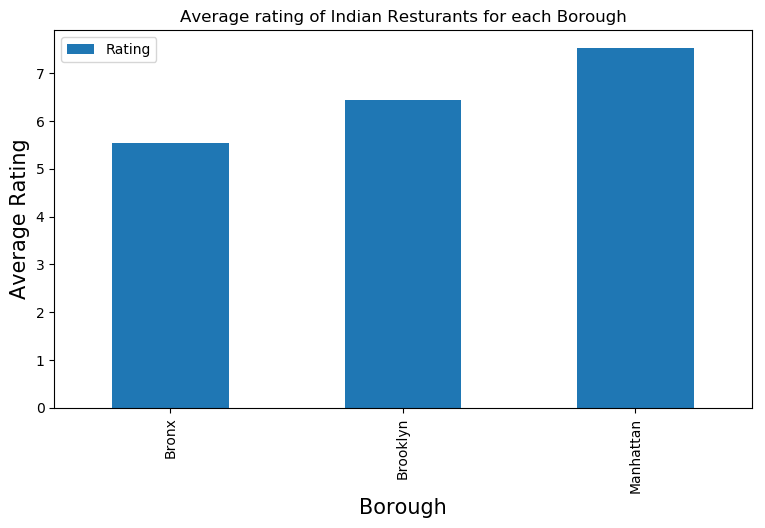

In [31]:
# Visualization
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [32]:
#consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [33]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bay Ridge,8.300000
2,Central Harlem,8.100000
3,Chelsea,8.700000
5,Clinton Hill,8.700000
7,East Flatbush,8.100000
10,Fort Greene,8.700000
15,Murray Hill,8.800000
16,Ocean Hill,8.050000
20,Roosevelt Island,8.400000
24,Upper West Side,8.133333


In [34]:
#join this dataset to original new york data to get lonitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [35]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,8.300000
1,Manhattan,Central Harlem,40.815976,-73.943211,8.100000
2,Manhattan,Chelsea,40.744035,-74.003116,8.700000
3,Staten Island,Chelsea,40.594726,-74.189560,8.700000
4,Brooklyn,Clinton Hill,40.693229,-73.967843,8.700000
5,Brooklyn,East Flatbush,40.641718,-73.936103,8.100000
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.700000
7,Manhattan,Murray Hill,40.748303,-73.978332,8.800000
8,Queens,Murray Hill,40.764126,-73.812763,8.800000
9,Brooklyn,Ocean Hill,40.678403,-73.913068,8.050000


In [36]:
# Display data on map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [37]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [38]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [39]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)